## CS310 Natural Language Processing
## Assignment 2. Word2vec Implementation 

**Total points**: 50

Train a word2vec model using the **skip-gram** architecture and **negative sampling**.

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from *Lab 4 (part 2): Data preparation for implementing word2vec*. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [20]:
from typing import List
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from torch.utils.data import Dataset, DataLoader
import re
import itertools
from collections import Counter
import gensim



### 1. Data Processing

The corpus data is in `lunyu_20chapters.txt`. Use the `CorpusReader` class in `utils.py` to help you.

In [21]:
# Read raw data in lunyu_20chapters.txt

### YOUR CODE HERE ###
corpus = CorpusReader(inputFileName="lunyu_20chapters.txt", min_count=1)
with open('lunyu_20chapters.txt', 'r', encoding='utf-8') as file:
    raw_data = file.read()
raw_data=raw_data.replace('\n','')
print(raw_data)
print(corpus.word2id["子"])
print(corpus.id2word[1])
print(len(corpus.id2word))
### END YOUR CODE ###

Total vocabulary: 1352
1
子
1352


In [22]:
# Re-use the code from lab with necessary modifications

def generate_data(words: List[str], window_size: int, k: int, corpus: CorpusReader):
    """ Generate the training data for word2vec skip-gram model
    Args:
        text: the input text
        window_size: the size of the context window
        k: the number of negative samples
        corpus: the corpus object, providing utilities such as word2id, getNegatives, etc.
    """
    ### YOUR CODE HERE ###
    word_ids = [corpus.word2id[word] for word in words if word in corpus.word2id]  # Convert words to word IDs
    result=[]
    for i, center_word_id in enumerate(word_ids):
        start = max(0, i - window_size)
        end = min(len(word_ids), i + window_size + 1)
        outside_word_ids = [word_ids[j] for j in range(start, end) if j != i]
        for i in outside_word_ids:
            negative_samples = corpus.getNegatives(center_word_id, k)
            result.append((center_word_id,i,negative_samples))
    return result
    ### END YOUR CODE ###

def batchify(data: List, batch_size: int):
    """ Group a stream into batches and yield them as torch tensors.
    Args:
        data: a list of tuples
        batch_size: the batch size 
    Yields:
        a tuple of three torch tensors: center, outside, negative
    """
    assert batch_size < len(data) # data should be long enough
    result=[]
    for i in range(0, len(data), batch_size):
        batch = data[i:i + batch_size]
        if i > len(data) - batch_size: # if the last batch is smaller than batch_size, pad it with the first few data
            batch = batch + data[:i + batch_size - len(data)]
        
        ## YOUR CODE HERE ###
        
        center_ids = torch.tensor([item[0] for item in batch], dtype=torch.long)
        outside_ids = torch.tensor([item[1] for item in batch], dtype=torch.long)
        negative_ids = torch.tensor(np.vstack([item[2] for item in batch]), dtype=torch.long)

        result.append((center_ids, outside_ids, negative_ids))
    return result
        ### END YOUR CODE ###


### 2. Build the Model

In [25]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, emb_size,word2id):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.emb_size = emb_size
        self.emb_v = nn.Embedding(vocab_size, emb_size, sparse=True)
        self.emb_u = nn.Embedding(vocab_size, emb_size, sparse=True)
        self.word2id = word2id
        initrange = 1.0 / self.emb_size # some experience passed down from generation to generation
        nn.init.uniform_(self.emb_v.weight.data, -initrange, initrange) # same outcome as self.emb_v.weight.data.uniform_(-initrange, initrange)
        nn.init.constant_(self.emb_u.weight.data, 0) # same outcome as self.emb_u.weight.data.zero_()

    def forward(self, center, outside, negative):

        v_c = self.emb_v(center)
        u_o = self.emb_u(outside)
        u_n = self.emb_u(negative)
        
        ### YOUR CODE HERE ###
        positive_dot_product = torch.mul(v_c, u_o).sum(dim=1)
        positive_score = F.logsigmoid(torch.clamp(positive_dot_product, min=-10, max=10))

        negative_dot_product = torch.bmm(u_n, v_c.unsqueeze(2)).squeeze(2)
        negative_score = F.logsigmoid(torch.clamp(-negative_dot_product, min=-10, max=10))

        loss = -torch.sum(positive_score + torch.sum(negative_score, dim=1))  # Scalar

        return loss
    
    def save_embedding(self, id2word, file_name):
        embedding = self.emb_v.weight.cpu().data.numpy()
        with open(file_name, 'w') as f:
            f.write('%d %d\n' % (len(id2word), self.emb_size))
            for wid, w in id2word.items():
                e = ' '.join(map(lambda x: str(x), embedding[wid]))
                f.write('%s %s\n' % (w, e))

### 3. Train and Evaluate

In [29]:
def train(model, dataloader, optimizer,scheduler, epochs):
    # Write your own code for this train function
    # You don't need exactly the same arguments

    ### YOUR CODE HERE ###
    model.train()  # Set model to training mode
    device = torch.device("cpu")
    model.to(device)

    for epoch in range(epochs):
        total_loss = 0
        for i, (center, outside, negative) in enumerate(dataloader):
            center, outside, negative = center.to(device), outside.to(device), negative.to(device)
            
            optimizer.zero_grad()  # Reset gradients
            loss = model(center, outside, negative)
            loss.backward()  # Backpropagate
            
            # Optional: Clip gradients to avoid exploding gradients
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
            
            optimizer.step()  # Update weights
            
            total_loss += loss.item()
            
            if i % 1000 == 0:  # Print average loss every 100 batches
                print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {total_loss/(i+1):.4f}')
        
        # Optional: Adjust learning rate
        scheduler.step()

    ### END YOUR CODE ###



# Suggested hyperparameters
initial_lr = 0.025
batch_size = 16
emb_size = 50
window_size = 5
k = 10 # the number of negative samples, change with your own choice for better embedding performance
min_count = 1 # because our data is small. If min_count > 1, you should filter out those unknown words from the data in train() function
epochs=10

emb_sizes = [50, 100]
k_values = [5, 10, 15]
window_sizes = [1, 3, 5]
for emb_size, k, window_size in itertools.product(emb_sizes, k_values, window_sizes):
    print(f"------------------------embeddings_{emb_size}_{k}_{window_size}--------------------")
    model = SkipGram(len(corpus.word2id), emb_size,corpus.word2id)
    optimizer = torch.optim.SparseAdam(model.parameters(), lr=initial_lr) # or torch.optim.SparseAdam()
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs) # or torch.optim.lr_scheduler.StepLR()

    data = list(generate_data(list(raw_data), window_size, k, corpus=corpus))
    print(len(data))
    dataloader = batchify(data,batch_size)

    train(model, dataloader, optimizer, scheduler,epochs)
    file_name = f"embeddings_{emb_size}_{k}_{window_size}.txt"
    model.save_embedding(corpus.id2word, file_name)

### Hints: ###
# - If you have cuda-supported GPUs, you can run the training faster by
#   `device = torch.device("cuda" if self.use_cuda else "cpu")`
#   `model.cuda()`
#   You also need to move all tensor data to the same device
# - If you find Inf or NaN in the loss, you can try to clip the gradient usning `torch.nn.utils.clip_grad_norm_`
# - Remember to save the embeddings when training is done

------------------------embeddings_50_5_1--------------------
39746
Epoch 1, Batch 1, Loss: 66.5421
Epoch 1, Batch 1001, Loss: 50.0133
Epoch 1, Batch 2001, Loss: 48.0302
Epoch 2, Batch 1, Loss: 37.7000
Epoch 2, Batch 1001, Loss: 40.8148
Epoch 2, Batch 2001, Loss: 39.1418
Epoch 3, Batch 1, Loss: 30.0000
Epoch 3, Batch 1001, Loss: 34.1727
Epoch 3, Batch 2001, Loss: 33.0112
Epoch 4, Batch 1, Loss: 20.3534
Epoch 4, Batch 1001, Loss: 30.2046
Epoch 4, Batch 2001, Loss: 29.4161
Epoch 5, Batch 1, Loss: 18.7724
Epoch 5, Batch 1001, Loss: 27.9847
Epoch 5, Batch 2001, Loss: 27.3182
Epoch 6, Batch 1, Loss: 19.2671
Epoch 6, Batch 1001, Loss: 26.5220
Epoch 6, Batch 2001, Loss: 25.9266
Epoch 7, Batch 1, Loss: 19.9626
Epoch 7, Batch 1001, Loss: 25.5818
Epoch 7, Batch 2001, Loss: 24.9791
Epoch 8, Batch 1, Loss: 20.7723
Epoch 8, Batch 1001, Loss: 24.9407
Epoch 8, Batch 2001, Loss: 24.2956
Epoch 9, Batch 1, Loss: 21.4328
Epoch 9, Batch 1001, Loss: 24.5406
Epoch 9, Batch 2001, Loss: 23.8166
Epoch 10, Batc

In [30]:
from typing import List
from utils import CorpusReader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from torch.utils.data import Dataset, DataLoader
import re
import gensim.downloader as api

### 4. Plot and Compare Embeddings

Use `sklearn.decomposition.TruncatedSVD` to reduce the dimensionality of the obtained embeddings to 2 and plot the selected words in 2D space.

*Hint*:
- Obtain the embeddings into a numpy array by `model.emb_v.cpu().data.numpy()`
- The word2id dictionary is in `model.word2id`
- If you are trying to load from a saved embedding file, you can use the APIs from `gensim`.
  - For exmaple, `model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')`
  - Check out the documentation for more details: https://radimrehurek.com/gensim/models/keyedvectors.html

In [31]:
# Load embeddings
### YOUR CODE HERE ###
def lsa():
    documents = []
    with open(f"lunyu_20chapters.txt", "r") as f:
        for line in f:
            documents.append(line.strip())
    documents = [document.replace(' ', '') for document in documents]
    words: str = ''.join(documents)
    vocab = Counter(words)
    print(vocab.most_common(10))
    word2index = {char: idx for idx, (char, _) in enumerate(vocab.most_common())}
    print(list(itertools.islice(word2index.items(), 10)))
    vocab_size = len(vocab) 
    num_documents = len(documents) 
    A = np.zeros((vocab_size, num_documents))
    for i, d in enumerate(documents): 
        for character in d:  
            if character in word2index: 
                w = word2index[character]  
                A[w, i] += 1  
    return A,word2index


# model = gensim.models.KeyedVectors.load_word2vec_format('path/to/file')
SkipGram_embeddings = model.emb_v.weight.detach().cpu().numpy()
word2id_skipgram= model.word2id
LSA_embeddings,word2id_lsa=lsa()
### END YOUR CODE ###

[('，', 1591), ('子', 972), ('。', 857), ('：', 788), ('曰', 758), ('之', 613), ('不', 583), ('也', 532), ('而', 342), ('？', 303)]
[('，', 0), ('子', 1), ('。', 2), ('：', 3), ('曰', 4), ('之', 5), ('不', 6), ('也', 7), ('而', 8), ('？', 9)]


In [32]:
# Truncated SVD
### YOUR CODE HERE ###
svd = TruncatedSVD(n_components=2)
reduced_SkipGram_embeddings = svd.fit_transform(SkipGram_embeddings)
reduced_LSA_embeddings=svd.fit_transform(LSA_embeddings)
### END YOUR CODE ###

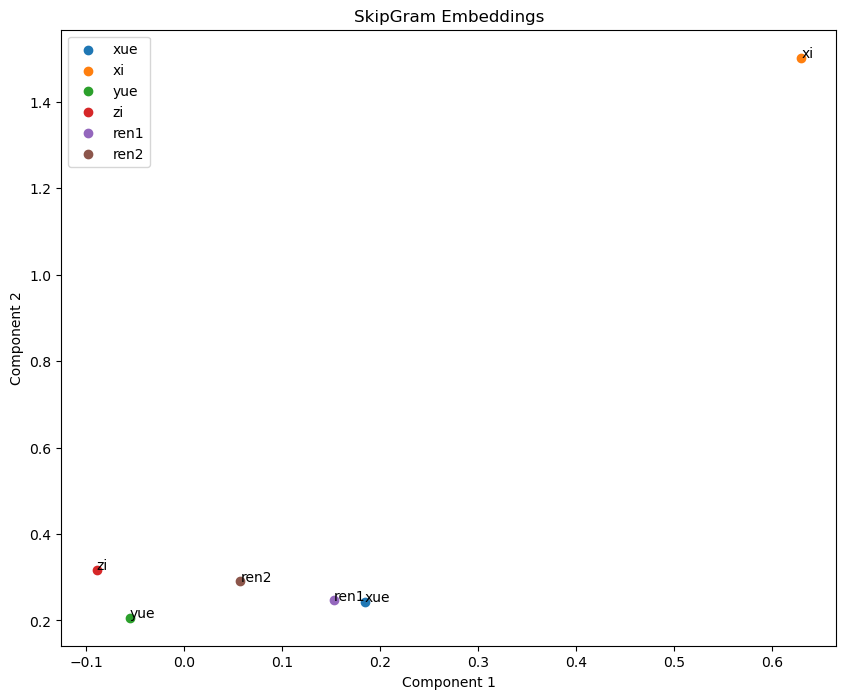

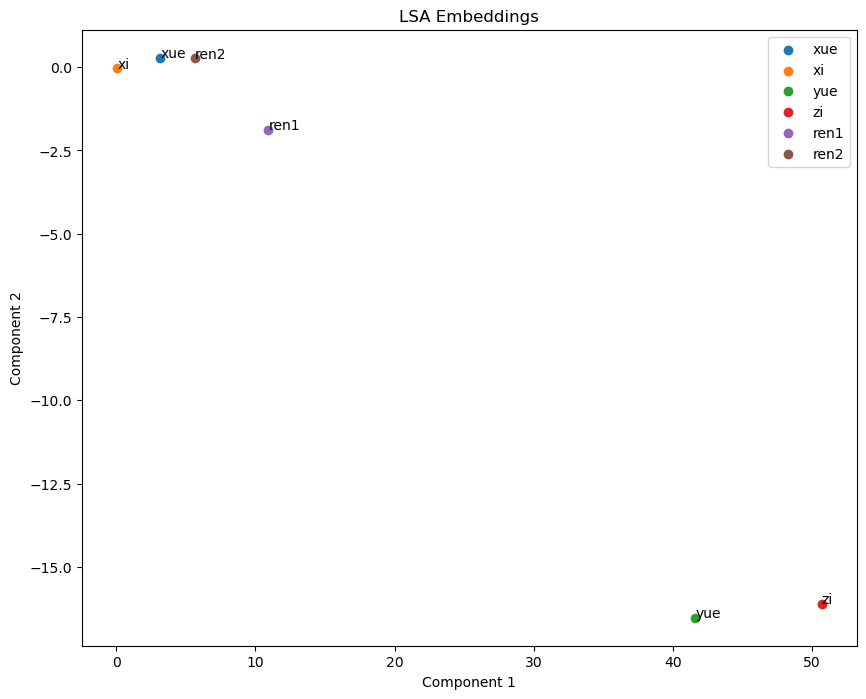

In [33]:
# Plot the following words or other words you are interested in
# You better pick those words that look different in the 2D space compared with the LSA vectors
target_words = ['学', '习', '曰', '子', '人', '仁']
words_pinyin = ['xue', 'xi', 'yue', 'zi', 'ren1', 'ren2']
def plot_embeddings(reduced_embeddings, words, title, word2id,save_file_name):
    plt.figure(figsize=(10, 8))
    for i,word in enumerate(words):
        if word in word2id:
            idx = word2id[word]
            plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=words_pinyin[i])
            plt.text(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], words_pinyin[i])

    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(title)
    plt.savefig(save_file_name)
    plt.legend()
    plt.show()

plot_embeddings(reduced_SkipGram_embeddings, target_words, "SkipGram Embeddings", word2id_skipgram,"SkipGram_Embeddings.png")
plot_embeddings(reduced_LSA_embeddings, target_words, "LSA Embeddings", word2id_lsa,"LSA_Embeddings.png")
### END YOUR CODE ###

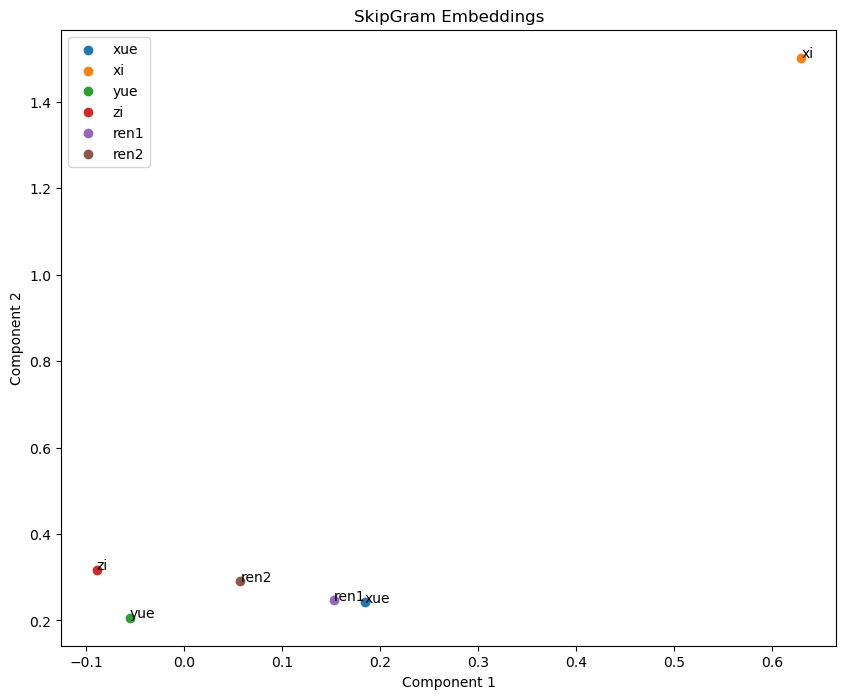

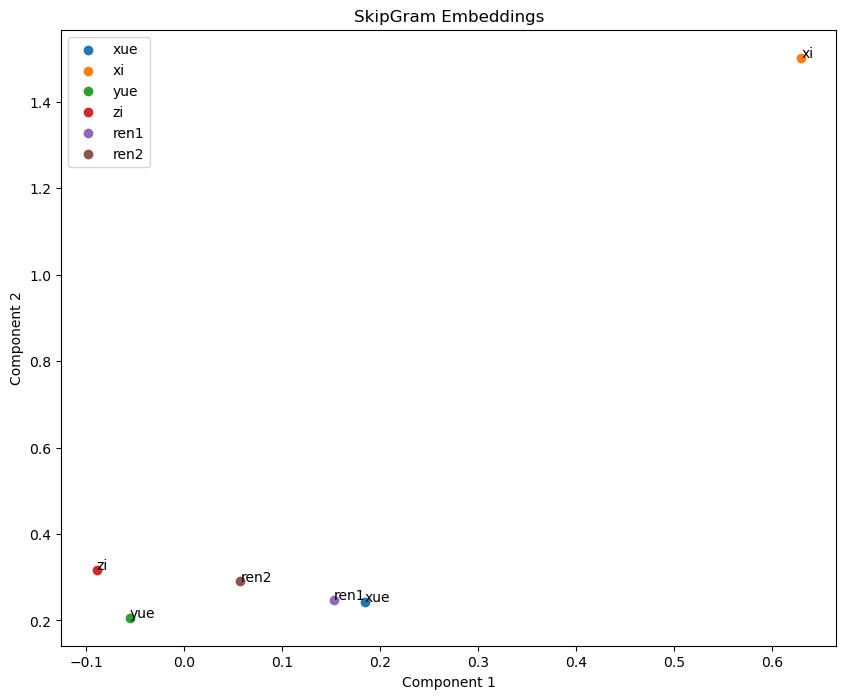

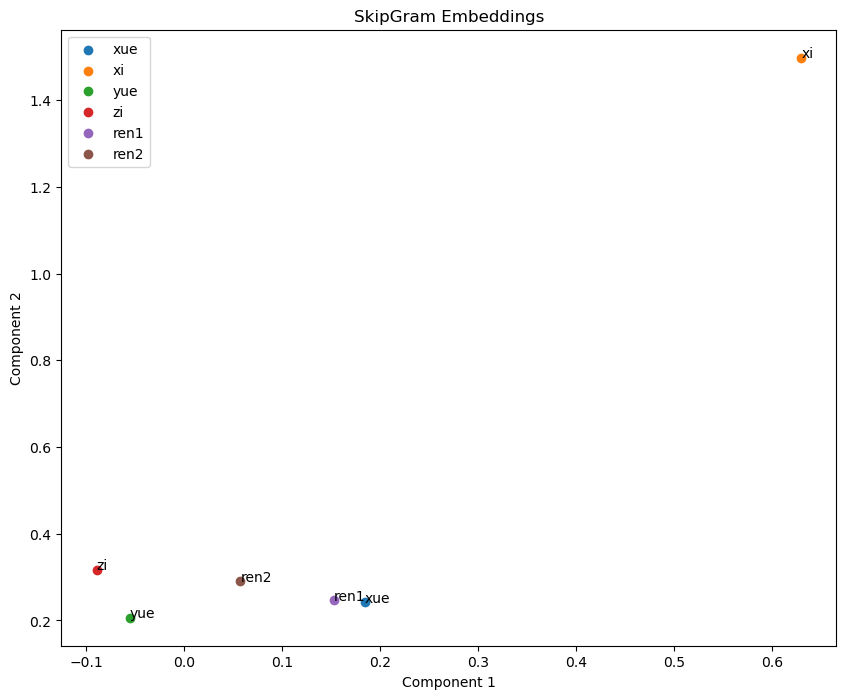

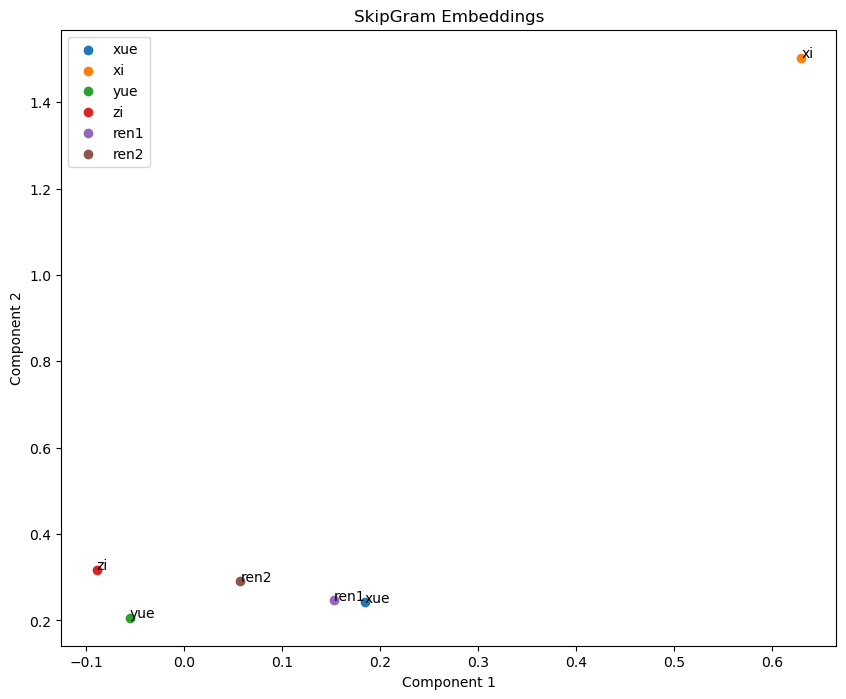

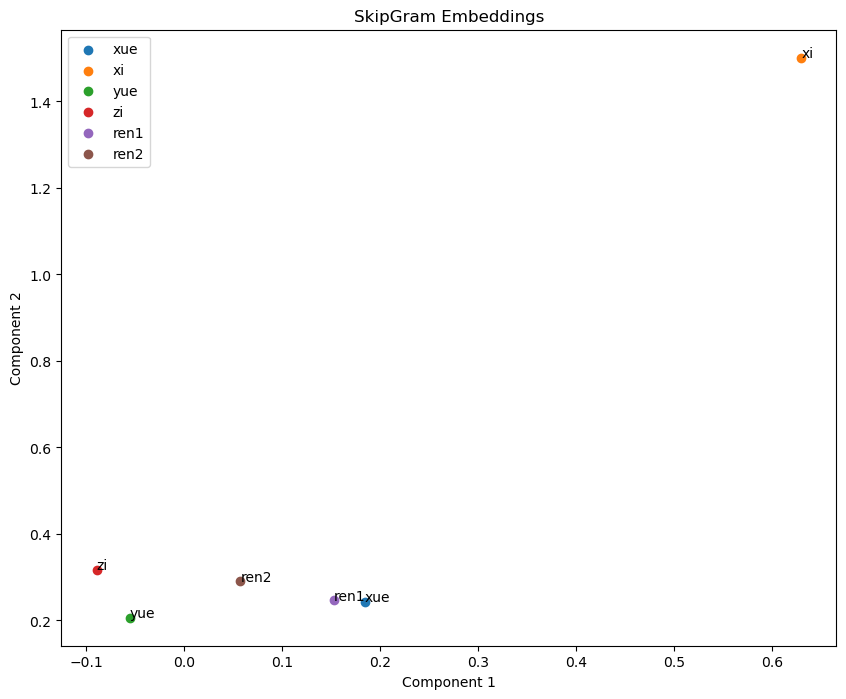

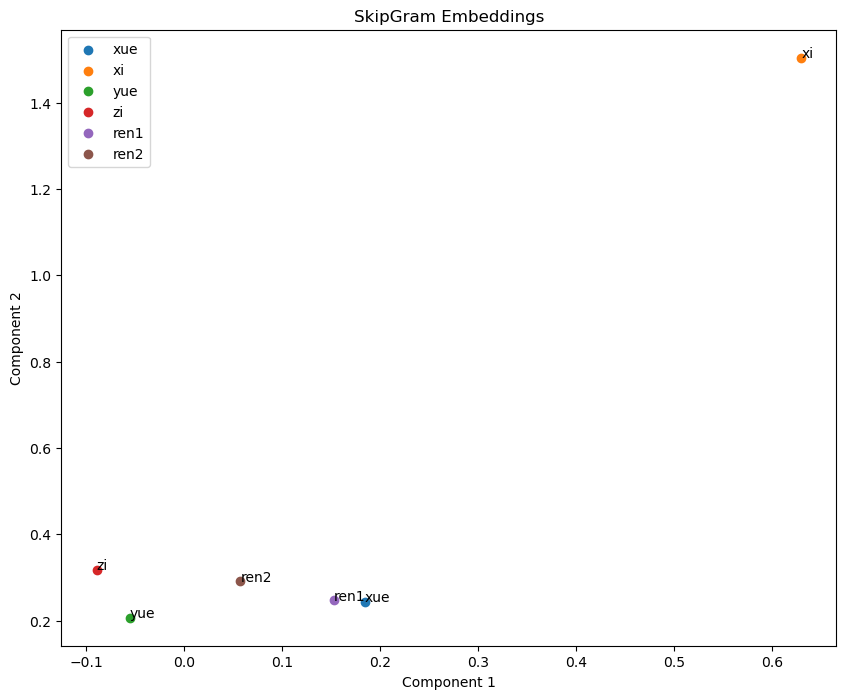

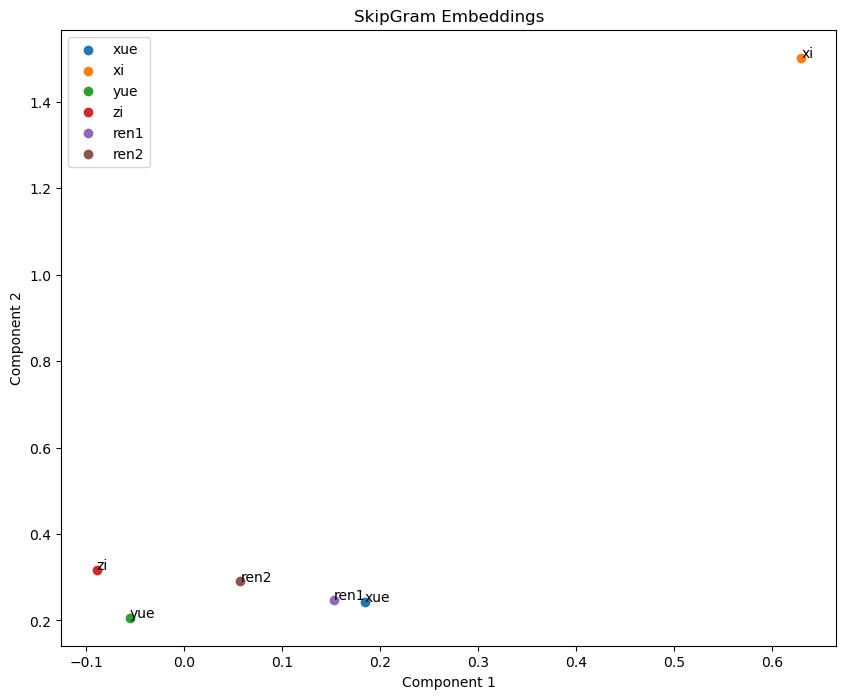

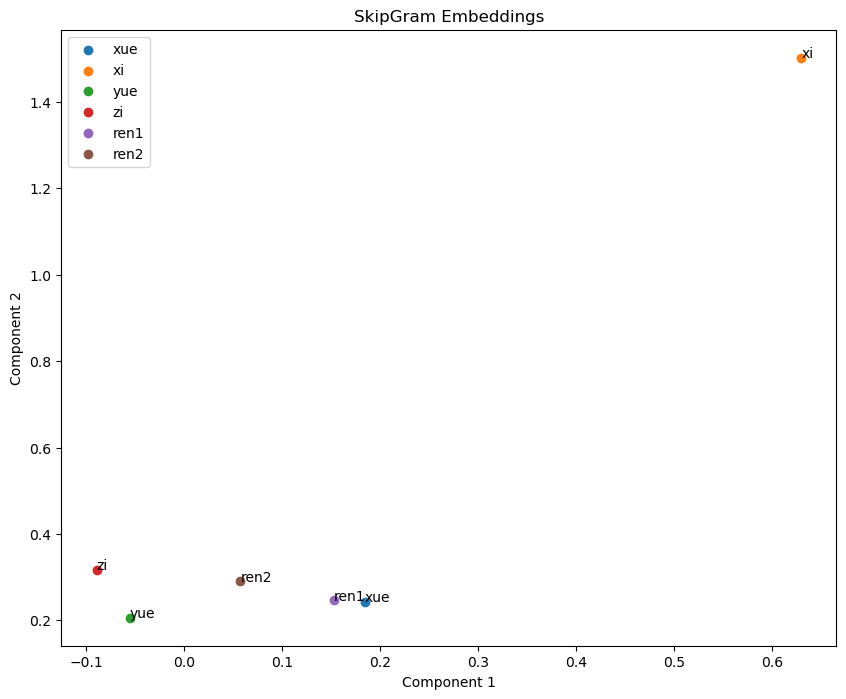

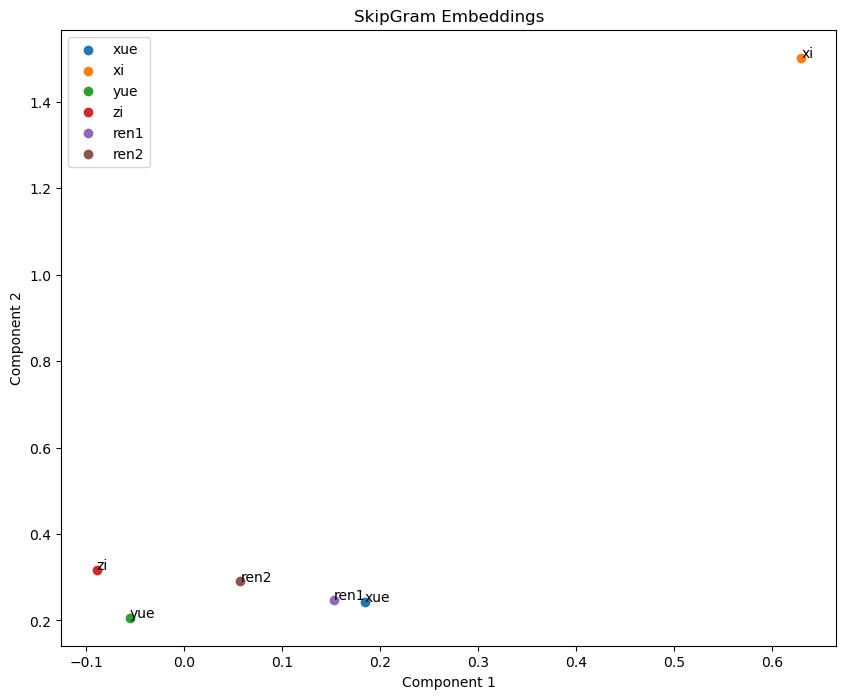

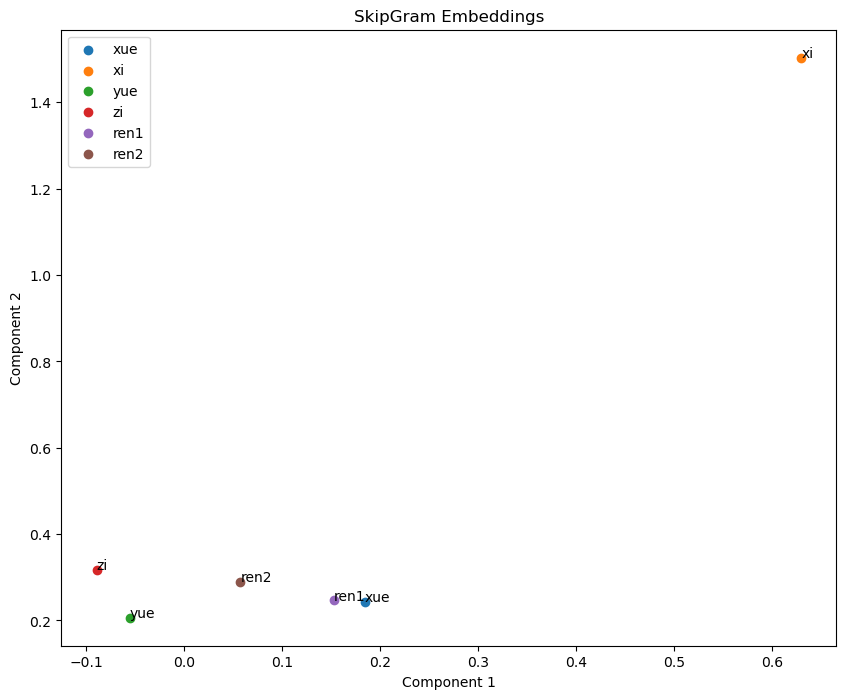

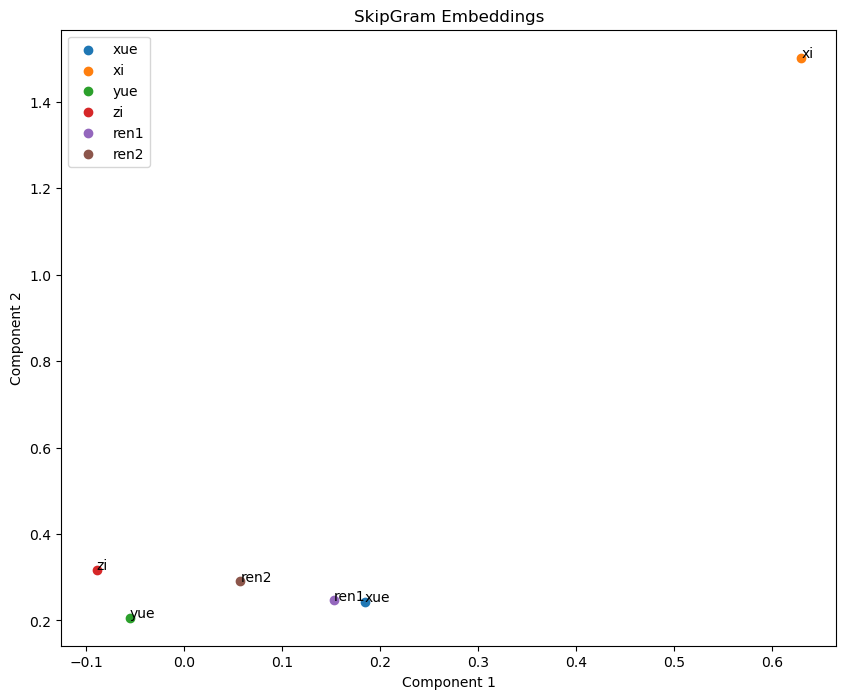

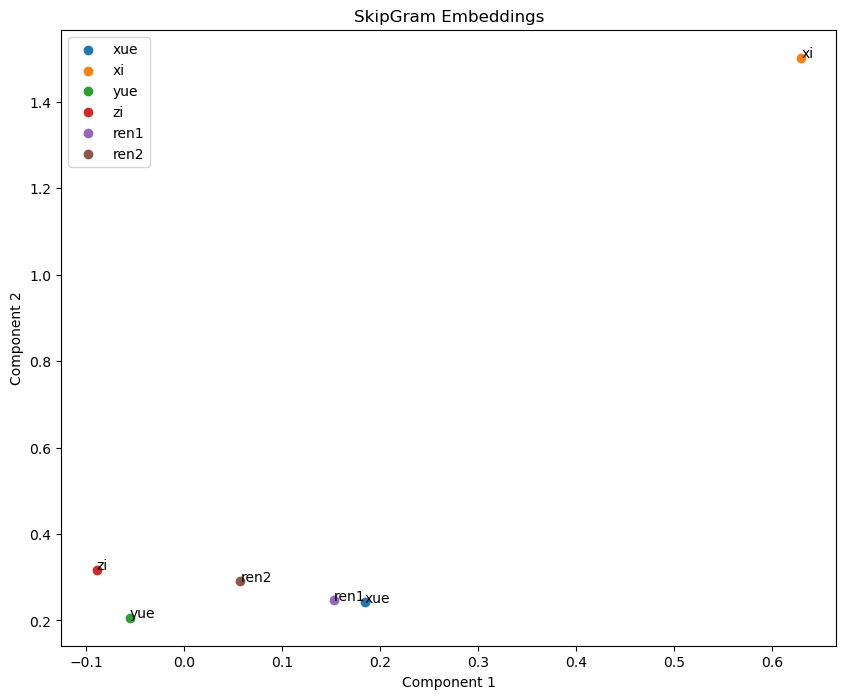

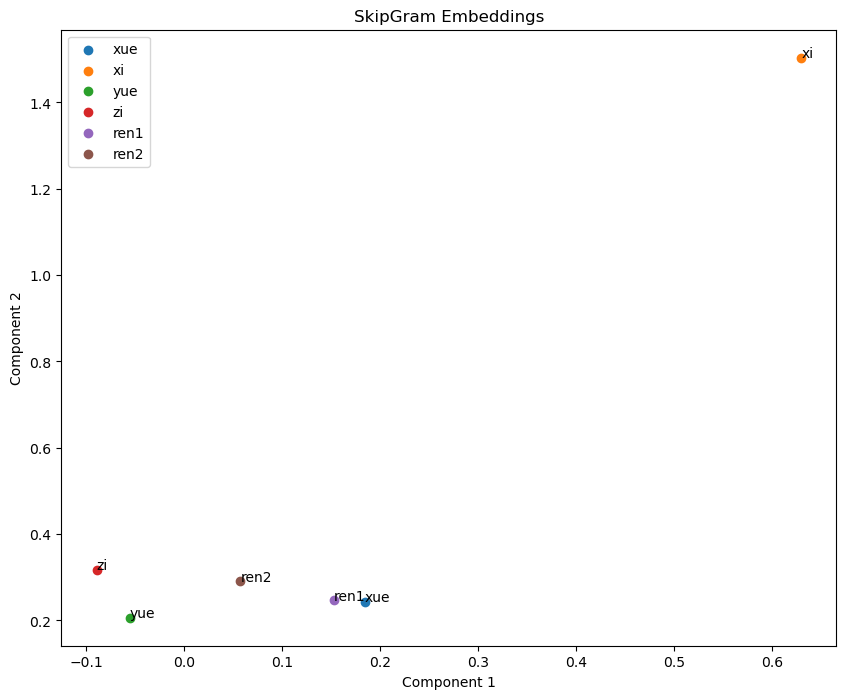

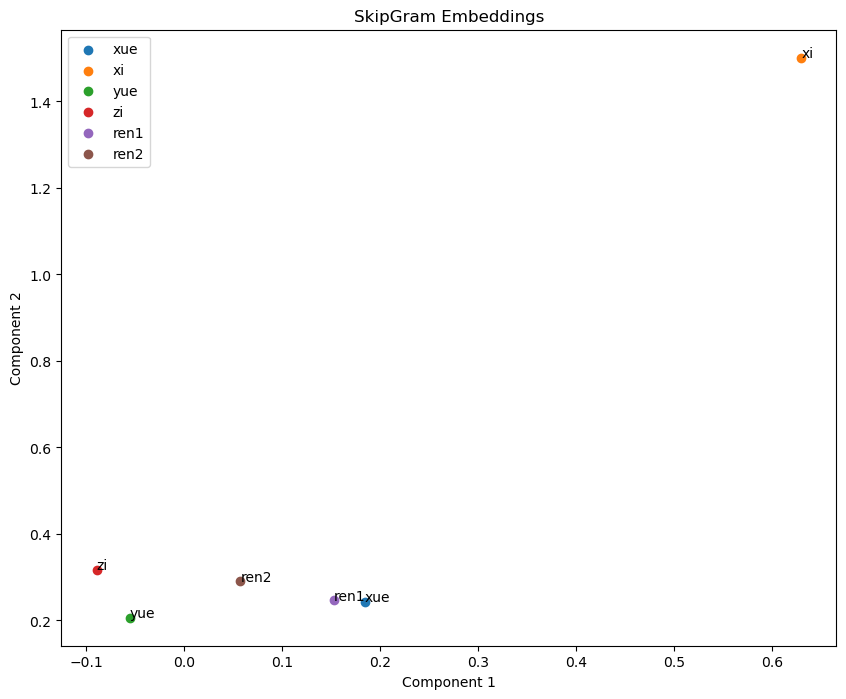

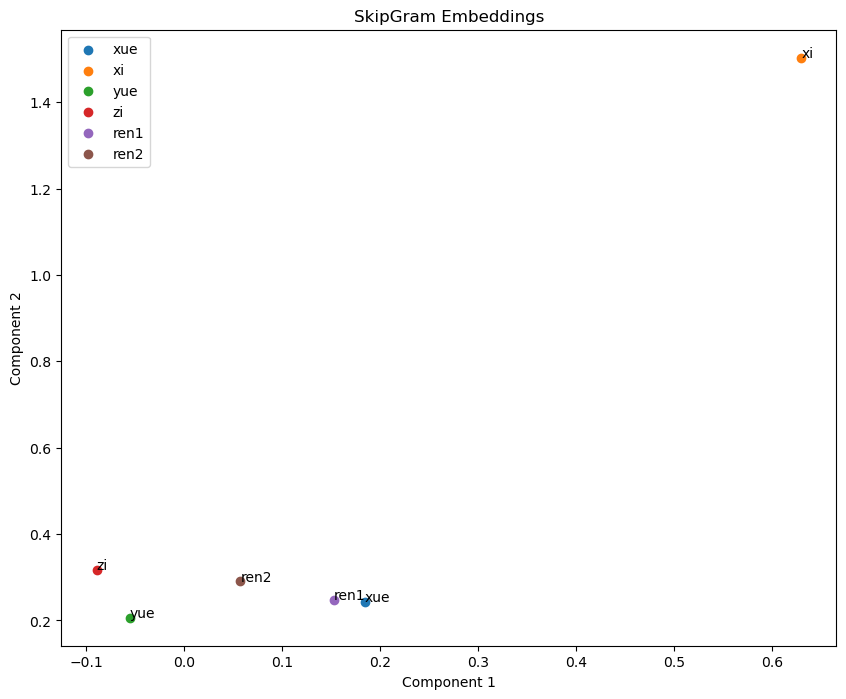

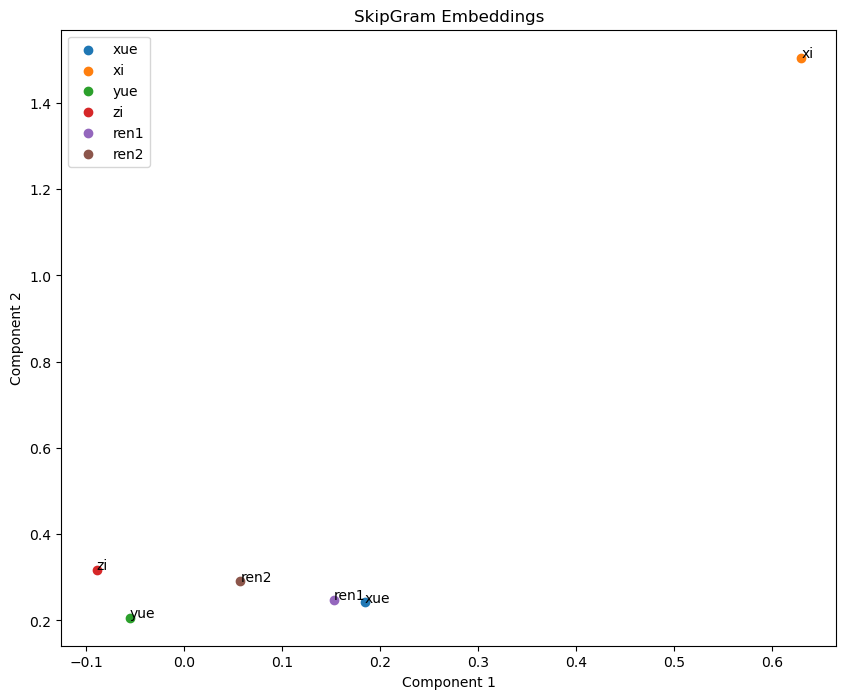

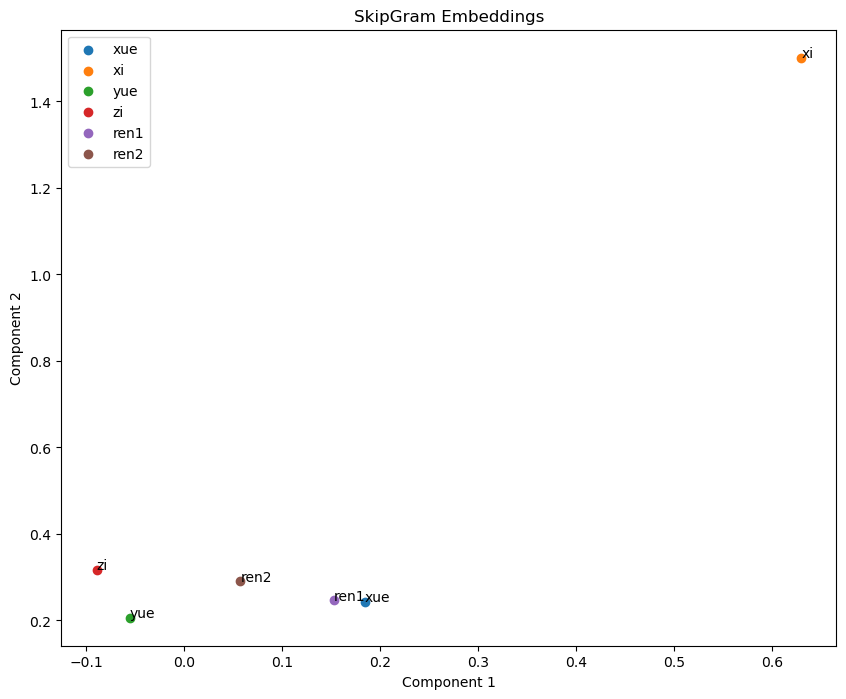

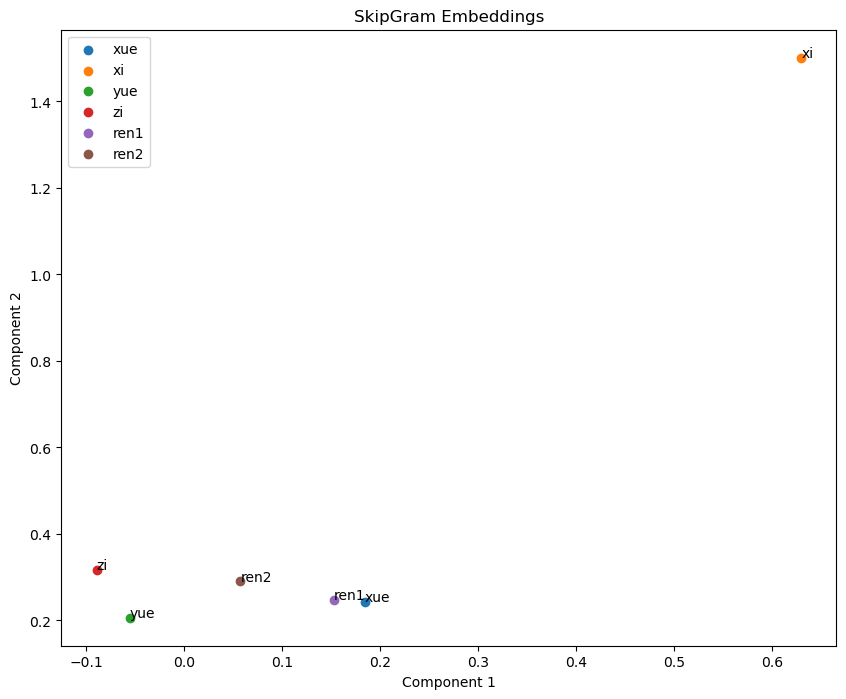

In [34]:
#load 18 embedings and plt
for emb_size, k, window_size in itertools.product(emb_sizes, k_values, window_sizes):
    model = gensim.models.KeyedVectors.load_word2vec_format(f'embeddings_{emb_size}_{k}_{window_size}.txt')
    word2id_skipgram= corpus.word2id
    svd = TruncatedSVD(n_components=2)
    reduced_SkipGram_embeddings = svd.fit_transform(SkipGram_embeddings)
    plot_embeddings(reduced_SkipGram_embeddings, target_words, "SkipGram Embeddings", word2id_skipgram,f'embeddings_{emb_size}_{k}_{window_size}.png')
